In [37]:
from PISNml import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [38]:
target_dict={90:'SNIa',67:'SNIa-91bg',
             52:'SNIax',42:'SNII',
             62:'SNIbc',95:'SLSN-I',
             15:'TDE',64:'KN',
             88:'AGN',92:'RRL',
             65:'M-dwarf',16:'EB',
             53:'Mira',6:'Lens-Single',
             994:'PISN', 999:'UNKNOWN',
             992 : 'ILOT', 993:'CaRT',
             995:'Lens-String',1:'NON PISN'}
passband_list = {0:'u',1:'g',2:'r',3:'i',4:'z',5:'y'}

In [39]:
cols = ['A','B','C','err','points','max_flux','nb_DB']
band_used = [2,3,4,5]
nb_band = len(band_used)
nb_param = len(cols)
nb_trees = 1000


sample = 'Iron/'
PISN_split = '-2_'
curve = 'Half/'
additional = '4p/'
model = 'poly'
purpose = 'test'
file = 'FUSED'
extras=''

target = 994

data = pd.read_pickle("../../plasticc/param_table/"+sample+curve+additional+purpose+PISN_split+model+extras+file+".pkl")

In [42]:
# Create model
table_score = create_if(data,band_used,nb_param,nb_trees)

In [40]:
def score_top(thresh,band):
    close = top_score[(top_score['threshold(%)']>thresh)&(top_score['threshold(%)']<thresh+0.01)]
    if band!= 0 :
        return close['score'+str(band)].iloc[0]
    else :
        return close['score'].iloc[0]

In [73]:
top_score = table_score.sort_values(by =('score'), ignore_index=True)
top_score['threshold(%)'] = 100*top_score.index/len(top_score);
top = top_score[top_score['target']==target]

top[:10]

,score,target,object_id,threshold(%)
128,-0.141364,994,556954392,0.016230
241,-0.130724,994,298087972,0.030558
243,-0.130485,994,825865951,0.030812
287,-0.126658,994,1077380822,0.036391
316,-0.124500,994,656113531,0.040068
456,-0.117566,994,1013931912,0.057820
705,-0.106931,994,755269001,0.089393
770,-0.104625,994,493207012,0.097634
805,-0.103541,994,726031712,0.102072


In [45]:
top_score.loc[top_score['target']==target,'threshold(%)']
targetofinterest = np.unique(data['target'])
targetofinterest

array([ 15,  42,  52,  62,  64,  67,  90,  95, 992, 993, 994])

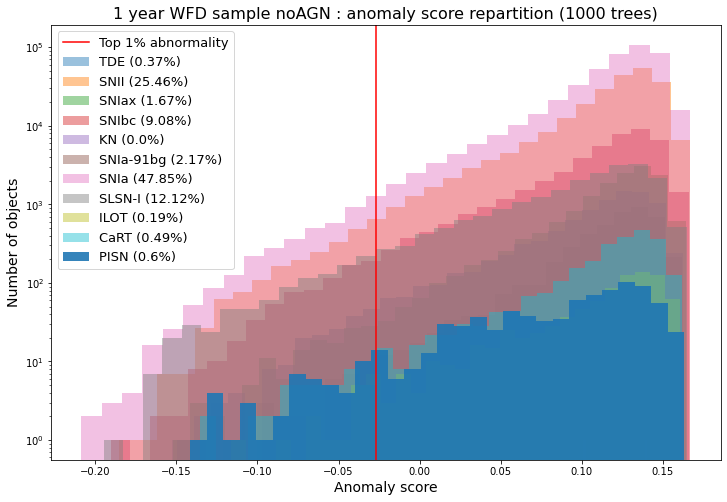

In [68]:
top_percent = 1

plt.figure(figsize = (12,8))
plt.yscale("log")


plt.title('Anomaly score repartition (%s trees)'%nb_trees,fontsize = 16)
for i in targetofinterest:
    nbre_conta = len(top_score.loc[(top_score['threshold(%)']<=top_percent)&(top_score['target']==i)])
    nbre_onepercent = len(top_score[top_score['threshold(%)']<=top_percent])
    percent_conta = round(nbre_conta*100/nbre_onepercent,2)
    if i == target:
        transparence = 0.9
    else :
        transparence = 0.45
    plt.hist(top_score.loc[top_score['target']==i,'score'],bins=30,label = target_dict.get(i)+' ('+str(percent_conta)+'%)',alpha = transparence);

nbre_conta = len(top_score.loc[(top_score['threshold(%)']<=top_percent)&(top_score['target']==target)])
nbre_onepercent = len(top_score[top_score['threshold(%)']<=top_percent])
percent_conta = round(nbre_conta*100/nbre_onepercent,2)


plt.xlabel('Anomaly score',fontsize = 14)
plt.ylabel('Number of objects',fontsize = 14)

plt.axvline(x=score_top(top_percent,0),color='red',label='Top '+str(top_percent)+ '% abnormality')
plt.legend(fontsize = 13)
#plt.savefig("IronHalfnoAGN_hist_anomaly(100t).png")

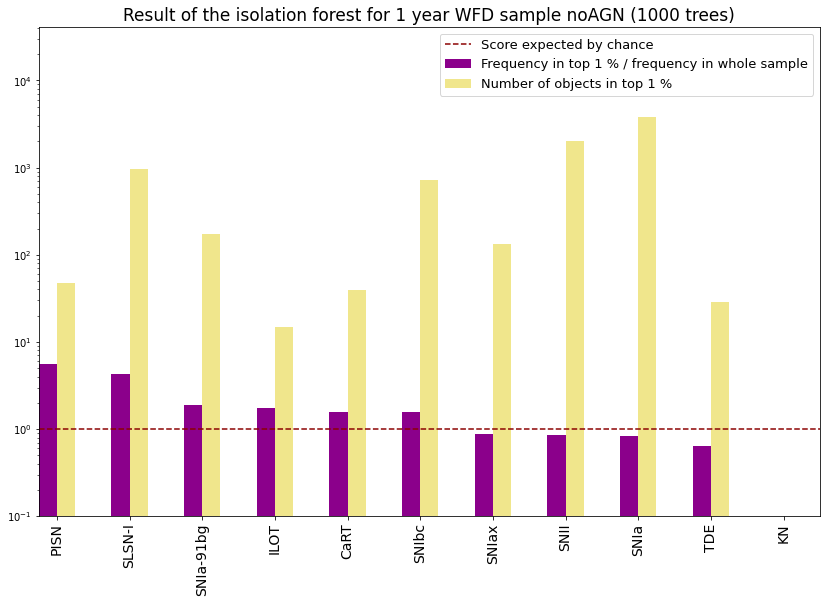

In [69]:
nb_1=np.array([])
nb_tot=np.array([])
targets=np.array([])
for i in targetofinterest:
    nb_tot = np.append(nb_tot,len(top_score[top_score['target']== i]))
    nb_1 = np.append(nb_1,len(top_score[(top_score['target']== i) & (top_score['threshold(%)']<=top_percent)]))
    targets = np.append(targets,target_dict.get(i))
    

all_tot = len(top_score)
all_1 = len(top_score[top_score['threshold(%)']<=top_percent])

proportion = (nb_1/all_1)/(nb_tot/all_tot)

d = {'useless': np.ones(len(proportion)),'ratio': proportion, 'nb_in_top1': nb_1, "targets":targets}
df = pd.DataFrame(data=d)
df = df.sort_values('ratio',ascending=False)

fig = plt.figure(figsize=(14,9)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes

width = 0.25

df.iloc[:len(targetofinterest)].ratio.plot(kind='bar', color='darkmagenta', ax=ax, width=width, position=1,label = 'Frequency in top %s %% / frequency in whole sample'%top_percent)

df.iloc[:len(targetofinterest)].nb_in_top1.plot(kind='bar', color='khaki', ax=ax, width=width, position=0,logy = True,label = 'Number of objects in top %s %%'%top_percent,alpha=1)

ax.set_xticklabels(df['targets'].iloc[:len(targetofinterest)],fontsize=14)
ax.set_ylim([0.1,41000])

plt.title('Result of the isolation forest (%s trees)'%nb_trees,fontsize=17)
ax.legend()

plt.axhline(y=1,color='darkred',label='Score expected by chance',linestyle ='--')
plt.legend(fontsize=13,loc='upper right')
#plt.savefig('ratio_HalfWFD_noAGN.png')
plt.show()


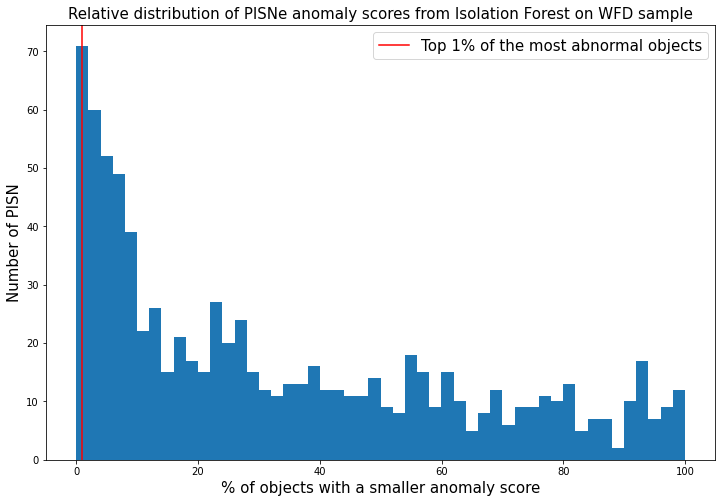

In [70]:
plt.figure(figsize = (12,8))

plt.hist(top_score.loc[top_score['target']==target,'threshold(%)'],bins=50);#top['threshold(%)']

plt.axvline(x=top_percent, ymax=100,color='red',label='Top top %s %% of the most abnormal objects'%top_percent)
plt.xlabel('% of objects with a smaller anomaly score',fontsize = 15)
plt.ylabel('Number of PISN',fontsize = 15)
plt.title('Relative distribution of PISNe anomaly scores from Isolation Forest on WFD sample',fontsize = 15)
plt.legend(fontsize=15)
#plt.savefig("Iron_hist_PISN.png")